# CPSC 368 Assignment 5: Data Analysis Project

## Group 9 - Time Series Forecasting 
- Shayan Abbaszadeh, 30008817
- Menarth Yovindu Anushan Udawattage Don, 45125309
- Shruti Vijaykumar Seetharam, 55121776
- Sarah Khashabioskuei, 17966854

In [1]:
#! pip install oracledb

username = "ora_shrutivs"
pw = "a55121776"

import oracledb
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user=username, password=pw, dsn=dsn)

## Load data

In [2]:
def generate_df(lst, name, cols):
    """
    lst: empty list for each dataframe
    
    name: name of table in schema (str)
    
    cols: list of column names for table
    """
    cur = connection.cursor()
    cur.execute(f"select * from {name}")
    res = cur.fetchall()
    for row in res:
        lst.append(row)
    cur.close()
    lst_df = pd.DataFrame(lst, columns = cols)
    return lst_df

In [3]:
# Load datasets 
continent_df = generate_df([], "Continent", ["continentName", "code"])
country_df = generate_df([], "Country", ["name", "continentName", "ISO3"])
sea_level_df = generate_df([], "SeaLevel", ["SealevelYear", "continentName", "unit", "GMSL"])
ghg_emission_df = generate_df([], "GHGEmission", ["ghgYear","unit"])
temperature_df = generate_df([], "Temperature", ["year", "ghgYear","unit"])
industry_df = generate_df([], "Industry", ["industryName"])
emitted_df = generate_df([], "Emitted", ["continentName", "ghgYear", "co2concentration"])
produces_df = generate_df([], "Produces", ["ghgYear", "industryName",  "totalco2concentration"])
temp_change_df = generate_df([], "TempChange", ["countryName", "year", "ghgYear", "temperature"])
# Dictionary of dataframes
dfs = {
    'Produces': produces_df,
    'Continent': continent_df,
    'Country': country_df,
    'GHG Emission': ghg_emission_df,
    'Industry': industry_df,
    'Sea Level': sea_level_df,
    'Emitted': emitted_df,
    'Temp Change': temp_change_df,
    'Temperature': temperature_df
}

# Display dataframes to ensure data was loaded properly
for name, df in dfs.items():
    print(f"{name}")
    print(df.head())

Produces
  ghgYear                                       industryName  \
0  2010Q1                  Agriculture, Forestry and Fishing   
1  2010Q1                                       Construction   
2  2010Q1  Electricity, Gas, Steam and Air Conditioning S...   
3  2010Q1                                      Manufacturing   
4  2010Q1                                             Mining   

   totalco2concentration  
0               34175.16  
1                3919.65  
2               64387.33  
3               48376.39  
4               20071.35  
Continent
        continentName    code
0                 G20   NA120
1       Southern Asia    NASA
2        Eastern Asia   NA510
3            Americas  AMETMP
4  South-eastern Asia   NASEA
Country
          name continentName ISO3
0       Israel  Western Asia  ISR
1      Austria        Europe  AUT
2  Isle of Man        Europe  IMN
3   Seychelles        Africa  SYC
4      Somalia        Africa  SOM
GHG Emission
  ghgYear                    

# Perform EDA

In [4]:
# Perform EDA for each dataframe
def eda(df, df_name):
    print(f"EDA for {df_name}:\n")

    # Descriptive Statistics
    print("Descriptive Statistics:")
    print(df.describe(), '\n')
    
    # Check for missing values
    print("Missing Values:")
    print(df.isnull().sum(), '\n')

    # Analyze unique values in categorical columns
    for column_name, data_type in df.select_dtypes(include=['object', 'category']).items():
        unique_count = data_type.nunique()
        print(f"Unique values in {column_name}: {unique_count}")

    # Separator
    print("--------------------------")
        
for name, df in dfs.items():
    eda(df, name)

EDA for Produces:

Descriptive Statistics:
       totalco2concentration
count             540.000000
mean            49609.572796
std             68944.803789
min              3844.570000
25%             11827.437500
50%             23571.280000
75%             53007.375000
max            269678.490000 

Missing Values:
ghgYear                  0
industryName             0
totalco2concentration    0
dtype: int64 

Unique values in ghgYear: 54
Unique values in industryName: 10
--------------------------
EDA for Continent:

Descriptive Statistics:
       continentName   code
count             25     25
unique            25     25
top              G20  NA120
freq               1      1 

Missing Values:
continentName    0
code             0
dtype: int64 

Unique values in continentName: 25
Unique values in code: 25
--------------------------
EDA for Country:

Descriptive Statistics:
          name continentName ISO3
count      172           172  172
unique     172            17  172
top  

# Data Cleaning

In [5]:
# Closer look at emmited_df, temp_change_df and sea_level_df as they will be directly relevant to further analysis

In [6]:
emitted_df.head()

,continentName,ghgYear,co2concentration
0,Advanced Economies,2010Q1,31192.12
1,Advanced Economies,2010Q2,29745.61
2,Advanced Economies,2010Q3,30135.84
3,Advanced Economies,2010Q4,31396.50
4,Advanced Economies,2011Q1,31369.16


In [7]:
# Turn quarterly data into Yearly
# Remove the quarter
emitted_df['Year'] = emitted_df['ghgYear'].str[:4]
# Take average of each quarter for each year
co2_yearly = emitted_df.groupby('Year')['co2concentration'].mean().reset_index()
# Ensure that it is numeric
co2_yearly['Year'] = pd.to_numeric(co2_yearly['Year'])
print(co2_yearly)

    Year  co2concentration
0   2010        18671.4862
1   2011        19183.8856
2   2012        19433.5127
3   2013        19755.3891
4   2014        19922.6071
5   2015        19823.8991
6   2016        19555.7569
7   2017        19862.7227
8   2018        20319.6518
9   2019        20333.9466
10  2020        19529.7904
11  2021        20428.2905
12  2022        20700.4174
13  2023        20740.6740


In [8]:
# Inspect temp_change_df
temp_change_df.head()

,countryName,year,ghgYear,temperature
0,Albania,2010,2010Q1,1.19
1,Albania,2010,2010Q2,1.19
2,Albania,2010,2010Q3,1.19
3,Albania,2010,2010Q4,1.19
4,Algeria,2010,2010Q1,2.26


In [9]:
# The temp per quarter is actually repeating so instead convert it to yearly
temp_change_df['Year'] = temp_change_df['year']
temp_yearly = temp_change_df.groupby('Year')['temperature'].mean().reset_index()
# Ensure that it is numeric
temp_yearly['Year'] = pd.to_numeric(temp_yearly['Year'])
print(temp_yearly)

    Year  temperature
0   2010     1.090727
1   2011     0.817831
2   2012     0.890671
3   2013     0.909455
4   2014     1.100303
5   2015     1.238242
6   2016     1.416933
7   2017     1.261534
8   2018     1.263765
9   2019     1.398589
10  2020     1.513558
11  2021     1.319632
12  2022     1.326442


In [10]:
# Inspect sea_level_yearly
sea_level_df.head()

,SealevelYear,continentName,unit,GMSL
0,1993,World,mm,-34.61
1,1994,World,mm,-30.95
2,1995,World,mm,-28.65
3,1996,World,mm,-26.60
4,1997,World,mm,-22.68


In [11]:
# Remove irrelevant columns and rename
sea_level_yearly = sea_level_df.groupby('SealevelYear')['GMSL'].mean().reset_index()
sea_level_yearly.rename(columns={'SealevelYear': 'Year', 'GMSL': 'GMSL'}, inplace=True)
# Ensure that it is numeric
sea_level_yearly['Year'] = pd.to_numeric(sea_level_yearly['Year'])
print(sea_level_yearly)

    Year   GMSL
0   1993 -34.61
1   1994 -30.95
2   1995 -28.65
3   1996 -26.60
4   1997 -22.68
5   1998 -25.06
6   1999 -21.81
7   2000 -18.43
8   2001 -13.22
9   2002  -9.37
10  2003  -6.32
11  2004  -4.43
12  2005  -0.03
13  2006   1.09
14  2007   1.49
15  2008   3.55
16  2009   8.41
17  2010   9.39
18  2011   8.43
19  2012  19.26
20  2013  21.30
21  2014  24.85
22  2015  35.42
23  2016  37.56
24  2017  38.38
25  2018  42.41
26  2019  49.30
27  2020  49.72
28  2021  50.03


In [12]:
#The three models have different year ranges. Set the time range from 2010 to 2021 as it is common for all three. 

co2_yearly = co2_yearly[(co2_yearly['Year'] >= 2010) & (co2_yearly['Year'] <= 2021)]
temp_yearly = temp_yearly[(temp_yearly['Year'] >= 2010) & (temp_yearly['Year'] <= 2021)]
sea_level_yearly = sea_level_yearly[(sea_level_yearly['Year'] >= 2010) & (sea_level_yearly['Year'] <= 2021)]

# Print the three tables
print(co2_yearly)
print(temp_yearly)
print(sea_level_yearly)

    Year  co2concentration
0   2010        18671.4862
1   2011        19183.8856
2   2012        19433.5127
3   2013        19755.3891
4   2014        19922.6071
5   2015        19823.8991
6   2016        19555.7569
7   2017        19862.7227
8   2018        20319.6518
9   2019        20333.9466
10  2020        19529.7904
11  2021        20428.2905
    Year  temperature
0   2010     1.090727
1   2011     0.817831
2   2012     0.890671
3   2013     0.909455
4   2014     1.100303
5   2015     1.238242
6   2016     1.416933
7   2017     1.261534
8   2018     1.263765
9   2019     1.398589
10  2020     1.513558
11  2021     1.319632
    Year   GMSL
17  2010   9.39
18  2011   8.43
19  2012  19.26
20  2013  21.30
21  2014  24.85
22  2015  35.42
23  2016  37.56
24  2017  38.38
25  2018  42.41
26  2019  49.30
27  2020  49.72
28  2021  50.03


## Correlational Analysis

In [13]:
# Merge the yearly data into a single DataFrame
merged_data = pd.merge(co2_yearly, temp_yearly, on='Year')
merged_data = pd.merge(merged_data, sea_level_yearly, on='Year')

# Rename columns for readability
merged_data.rename(columns={'co2concentration': 'CO2 Concentration', 'temperature': 'Temperature Change', 'GMSL': 'Sea Level Change'}, inplace=True)
print(merged_data)

    Year  CO2 Concentration  Temperature Change  Sea Level Change
0   2010         18671.4862            1.090727              9.39
1   2011         19183.8856            0.817831              8.43
2   2012         19433.5127            0.890671             19.26
3   2013         19755.3891            0.909455             21.30
4   2014         19922.6071            1.100303             24.85
5   2015         19823.8991            1.238242             35.42
6   2016         19555.7569            1.416933             37.56
7   2017         19862.7227            1.261534             38.38
8   2018         20319.6518            1.263765             42.41
9   2019         20333.9466            1.398589             49.30
10  2020         19529.7904            1.513558             49.72
11  2021         20428.2905            1.319632             50.03


In [14]:
# Calculate correlation matrix. The corr() function will compute the Pearson correlation coefficient .
correlation_matrix = merged_data[['CO2 Concentration', 'Temperature Change', 'Sea Level Change']].corr()

# Display the correlation matrix
print(correlation_matrix)

# The Pearson correlation coefficient ranges from -1 to 1 where 1 is a perfect positive linear relationship,
# -1 is a perfect negative linear relationship and 0 is no linear relationship.

                    CO2 Concentration  Temperature Change  Sea Level Change
CO2 Concentration            1.000000            0.432636          0.764605
Temperature Change           0.432636            1.000000          0.877595
Sea Level Change             0.764605            0.877595          1.000000


# Time Series Analysis : CO2

In [15]:
# AIC test to check if the data is stationary. If it is stationary the statistical properties like mean and variance do not change over time which is essential for a time series model
# Adapted usage of adfuller package from: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
def AIC_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
        
AIC_test(co2_yearly['co2concentration'])

ADF Statistic: 10.229574418539398
p-value: 1.0
	1%: -4.9386902332361515
	5%: -3.477582857142857
	10%: -2.8438679591836733


In [16]:
# Since the pvalue is high it is non statinary and the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) 
# could be investigated. But since the model has limited data points it can be applied with a basic ARIMA model of (1,1,1)

# Understanding of how statsmodel and ARIMA works: https://medium.com/@mubarakdaha/understanding-time-series-forecasting-with-arima-59cd7140d6c3
# Fitting an ARIMA model 
model_co2 = ARIMA(co2_yearly['co2concentration'], order=(1, 1, 1))
model_co2_fit = model_co2.fit()

# Display model summary
print(model_co2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       co2concentration   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -82.428
Date:                Fri, 22 Mar 2024   AIC                            170.855
Time:                        19:10:54   BIC                            172.049
Sample:                             0   HQIC                           170.103
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8606      0.293      2.942      0.003       0.287       1.434
ma.L1         -0.7965      0.398     -2.001      0.045      -1.577      -0.016
sigma2      1.969e+05    9.1e+04      2.163      0.0

In [17]:
# The model fits adequately so the forecasting can be completed
# Understanding of how statsmodel and ARIMA works: https://medium.com/@mubarakdaha/understanding-time-series-forecasting-with-arima-59cd7140d6c3

# Forecasting the next 5 years 
forecast_years = np.arange(2022, 2027)
forecast_co2 = model_co2_fit.get_forecast(steps=5)
forecast_co2_summary = forecast_co2.summary_frame()

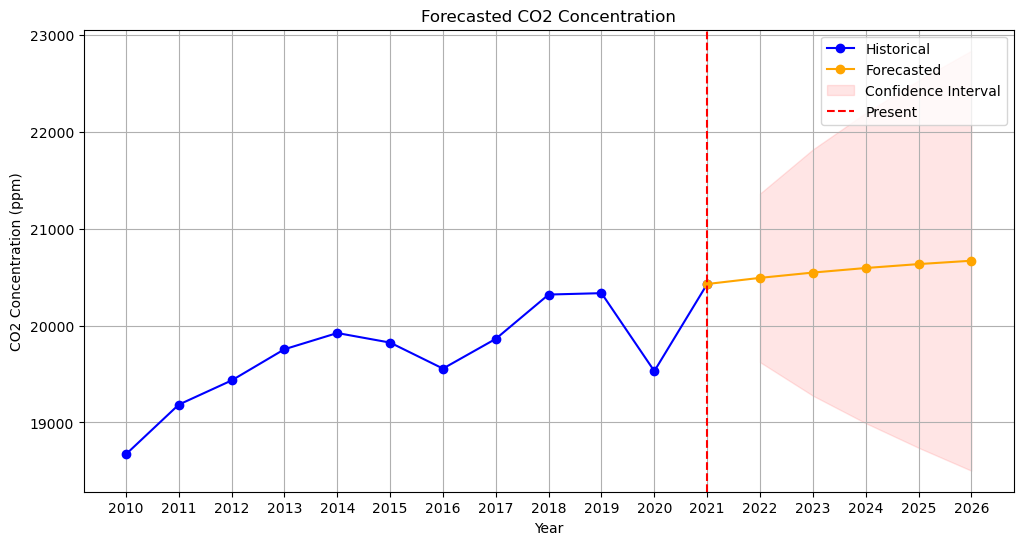

In [18]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(co2_yearly['Year'], co2_yearly['co2concentration'], marker='o', label='Historical', color='blue')
# Ensure the lines are connected
full_forecast_years = np.concatenate(([2021], forecast_years))
full_forecast_values = np.concatenate(([co2_yearly['co2concentration'].iloc[-1]], forecast_co2_summary['mean']))
# Plot forecasted data
plt.plot(full_forecast_years, full_forecast_values, marker='o', label='Forecasted', color='orange')
# Confidence Intervals
plt.fill_between(forecast_years, forecast_co2_summary['mean_ci_lower'], forecast_co2_summary['mean_ci_upper'], color='red', alpha=0.1, label='Confidence Interval')
# Present line
plt.axvline(x=2021, color='red', linestyle='--', label='Present')
plt.title('Forecasted CO2 Concentration')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
# Ensure axis is by each year. Adapted from: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
plt.xticks(np.arange(min(co2_yearly['Year']), max(full_forecast_years)+1, 1.0))  
plt.legend()
plt.grid(True)
plt.show()

# Time Series Analysis : Temperature

In [19]:
# AIC test
AIC_test(temp_yearly['temperature'])

ADF Statistic: -3.8568067295536186
p-value: 0.0023767512252669985
	1%: -4.9386902332361515
	5%: -3.477582857142857
	10%: -2.8438679591836733


In [20]:
# The p-value is low so the data is stationary. But the same Arima model will be followed for consitency as it has low data points. 
# Understanding of how statsmodel and ARIMA works: https://medium.com/@mubarakdaha/understanding-time-series-forecasting-with-arima-59cd7140d6c3

# Fitting an ARIMA model 
model_temp = ARIMA(temp_yearly['temperature'], order=(1, 1, 1))
model_temp_fit = model_temp.fit()

# Display model summary
print(model_temp_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                   12
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   5.170
Date:                Fri, 22 Mar 2024   AIC                             -4.340
Time:                        19:10:55   BIC                             -3.146
Sample:                             0   HQIC                            -5.092
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8471      1.406      0.602      0.547      -1.909       3.603
ma.L1         -0.9964     23.897     -0.042      0.967     -47.834      45.841
sigma2         0.0216      0.495      0.044      0.9

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
# Understanding of how statsmodel and ARIMA works: https://medium.com/@mubarakdaha/understanding-time-series-forecasting-with-arima-59cd7140d6c3
# Forecasting the next 5 years 
forecast_temp = model_temp_fit.get_forecast(steps=5)
forecast_temp_summary = forecast_temp.summary_frame()

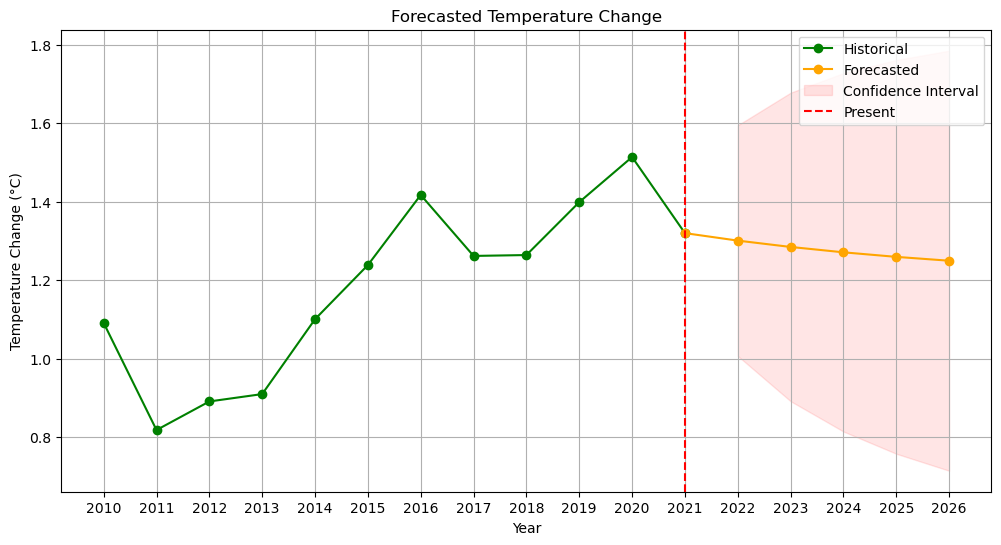

In [22]:
#Plot
plt.figure(figsize=(12, 6))
plt.plot(temp_yearly['Year'], temp_yearly['temperature'], marker='o', label='Historical', color='green')
# Ensure the lines are connected
full_forecast_years_temp = np.concatenate(([2021], forecast_years))
full_forecast_values_temp = np.concatenate(([temp_yearly['temperature'].iloc[-1]], forecast_temp_summary['mean']))
# Plot forecasted data
plt.plot(full_forecast_years_temp, full_forecast_values_temp, marker='o', label='Forecasted', color='orange')
# Confidence Intervals
plt.fill_between(forecast_years, forecast_temp_summary['mean_ci_lower'], forecast_temp_summary['mean_ci_upper'], color='red', alpha=0.1, label='Confidence Interval')
# Present line
plt.axvline(x=2021, color='red', linestyle='--', label='Present')
plt.title('Forecasted Temperature Change')
plt.xlabel('Year')
plt.ylabel('Temperature Change (°C)')
# Ensure axis is by each year. Adapted from: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
plt.xticks(np.arange(min(temp_yearly['Year']), max(full_forecast_years_temp)+1, 1.0))
plt.legend()
plt.grid(True)
plt.show()

# Time Series Analysis : Sea Level

In [23]:
# AIC test
AIC_test(sea_level_yearly['GMSL'])

ADF Statistic: -10.696040278346373
p-value: 3.6227205824433544e-19
	1%: -4.9386902332361515
	5%: -3.477582857142857
	10%: -2.8438679591836733


In [24]:
# The same Arima model will be followed for consitency as it has low data points.
# Understanding of how statsmodel and ARIMA works: https://medium.com/@mubarakdaha/understanding-time-series-forecasting-with-arima-59cd7140d6c3
# Fitting an ARIMA model 

# We fit an ARIMA(0, 1, 1) instead of a (1, 1, 1) model as we realized the auto-regressive parameters were non-stationary
model_sea_level = ARIMA(sea_level_yearly['GMSL'], order=(0, 1, 1))
model_sea_level_fit = model_sea_level.fit()

# Display model summary
print(model_sea_level_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   GMSL   No. Observations:                   12
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -33.409
Date:                Fri, 22 Mar 2024   AIC                             70.818
Time:                        19:10:56   BIC                             71.614
Sample:                             0   HQIC                            70.317
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4102      0.378      1.086      0.277      -0.330       1.150
sigma2        25.0218     11.841      2.113      0.035       1.815      48.229
Ljung-Box (L1) (Q):                   3.23   Jarque-

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
# Understanding of how statsmodel and ARIMA works: https://medium.com/@mubarakdaha/understanding-time-series-forecasting-with-arima-59cd7140d6c3
# Forecasting the next 5 years 
forecast_sea_level = model_sea_level_fit.get_forecast(steps=5)
forecast_sea_level_summary = forecast_sea_level.summary_frame()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


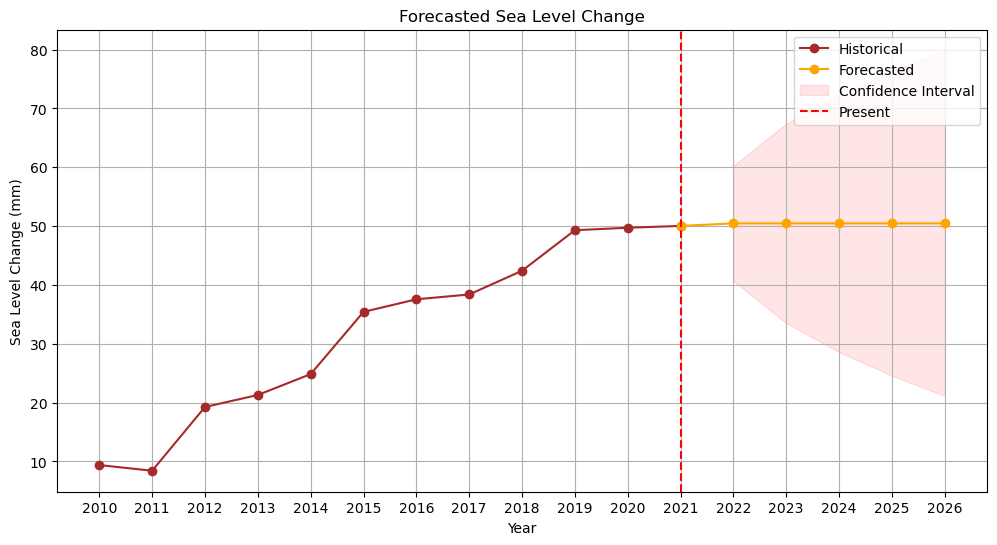

In [26]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(sea_level_yearly['Year'], sea_level_yearly['GMSL'], marker='o', label='Historical', color='brown')
# Ensure the lines are connected
full_forecast_years_sea = np.concatenate(([2021], forecast_years))
full_forecast_values_sea = np.concatenate(([sea_level_yearly['GMSL'].iloc[-1]], forecast_sea_level_summary['mean']))
# Plot forecasted data
plt.plot(full_forecast_years_sea, full_forecast_values_sea, marker='o', label='Forecasted', color='orange')
# Confidence Intervals
plt.fill_between(forecast_years, forecast_sea_level_summary['mean_ci_lower'], forecast_sea_level_summary['mean_ci_upper'], color='red', alpha=0.1, label='Confidence Interval')
# Present line
plt.axvline(x=2021, color='red', linestyle='--', label='Present')
plt.title('Forecasted Sea Level Change')
plt.xlabel('Year')
plt.ylabel('Sea Level Change (mm)')
# Ensure axis is by each year. Adapted from: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
plt.xticks(np.arange(min(sea_level_yearly['Year']), max(full_forecast_years_sea)+1, 1.0))  
plt.legend()
plt.grid(True)
plt.show()

# Final Visualization

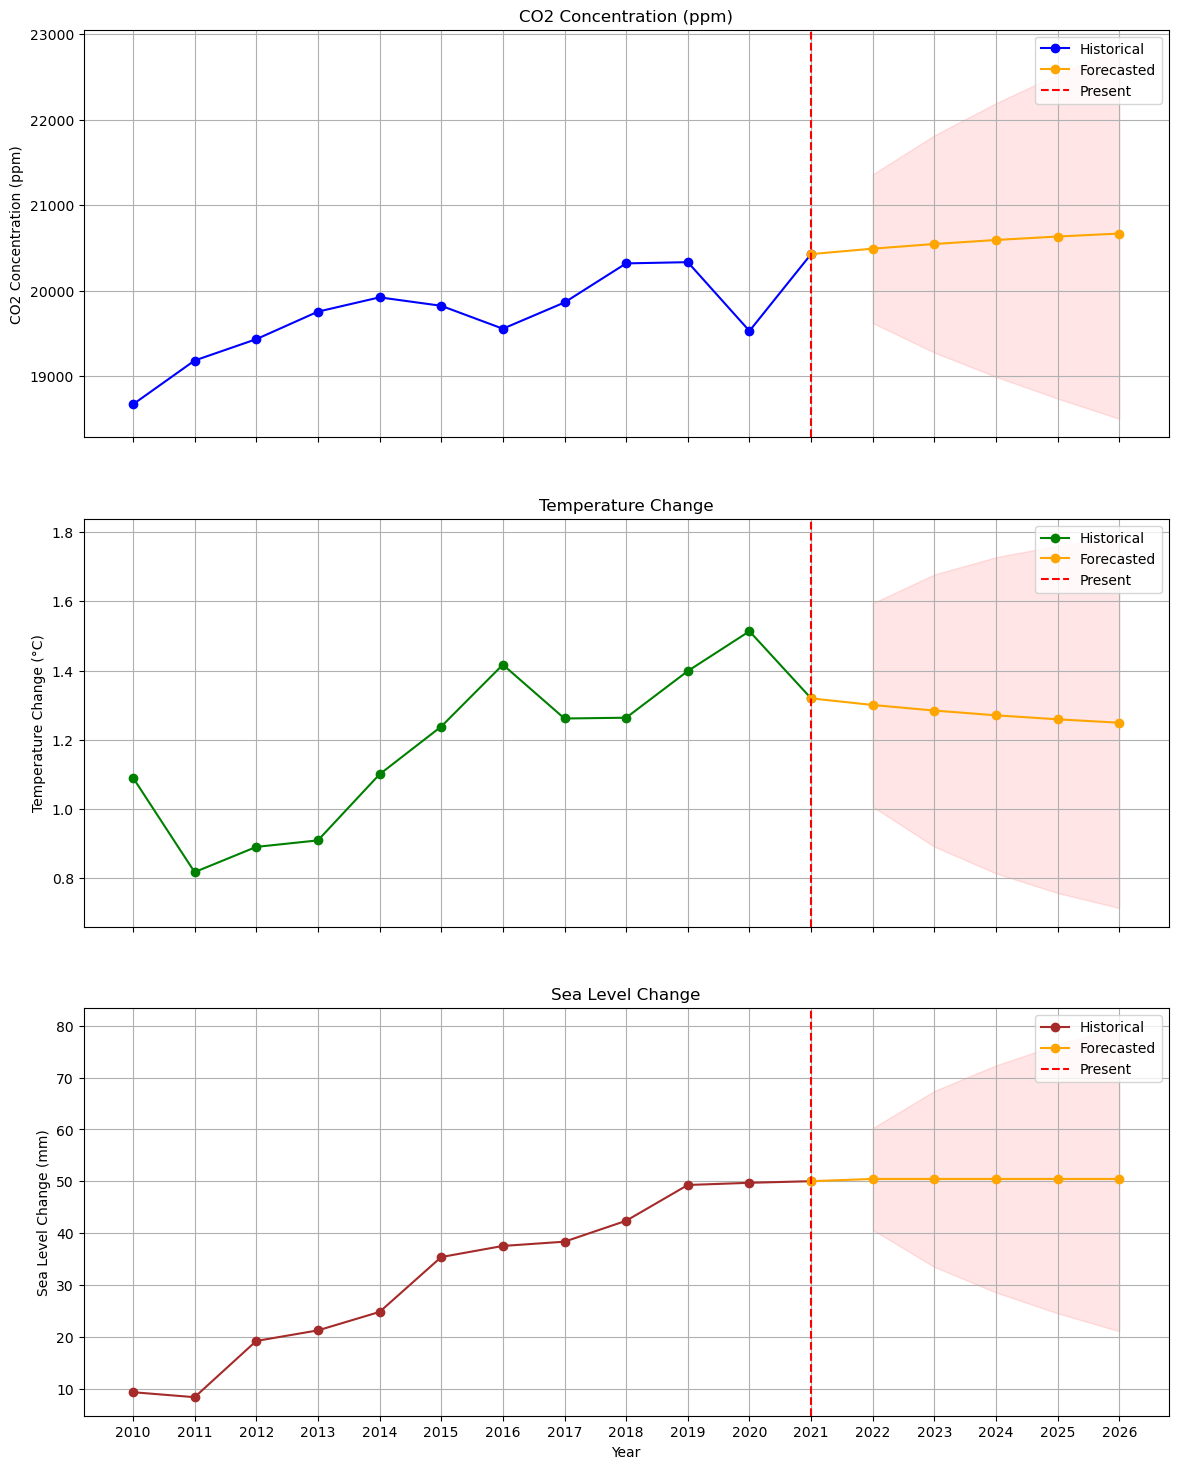

In [27]:
# Plot
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# CO2 Concentration Plot
axs[0].plot(co2_yearly['Year'], co2_yearly['co2concentration'], marker='o', label='Historical', color='blue')
axs[0].plot(full_forecast_years, full_forecast_values, marker='o', label='Forecasted', color='orange')
axs[0].fill_between(forecast_years, forecast_co2_summary['mean_ci_lower'], forecast_co2_summary['mean_ci_upper'], color='red', alpha=0.1)
axs[0].axvline(x=2021, color='red', linestyle='--', label='Present')
axs[0].set_title('CO2 Concentration (ppm)')
axs[0].set_ylabel('CO2 Concentration (ppm)')
axs[0].legend()
axs[0].grid(True)

# Temperature Change Plot
axs[1].plot(temp_yearly['Year'], temp_yearly['temperature'], marker='o', label='Historical', color='green')
axs[1].plot(full_forecast_years_temp, full_forecast_values_temp, marker='o', label='Forecasted', color='orange')
axs[1].fill_between(forecast_years, forecast_temp_summary['mean_ci_lower'], forecast_temp_summary['mean_ci_upper'], color='red', alpha=0.1)
axs[1].axvline(x=2021, color='red', linestyle='--', label='Present')
axs[1].set_title('Temperature Change')
axs[1].set_ylabel('Temperature Change (°C)')
axs[1].legend()
axs[1].grid(True)

# Sea Level Change Plot
axs[2].plot(sea_level_yearly['Year'], sea_level_yearly['GMSL'], marker='o', label='Historical', color='brown')
axs[2].plot(full_forecast_years_sea, full_forecast_values_sea, marker='o', label='Forecasted', color='orange')
axs[2].fill_between(forecast_years, forecast_sea_level_summary['mean_ci_lower'], forecast_sea_level_summary['mean_ci_upper'], color='red', alpha=0.1)
axs[2].axvline(x=2021, color='red', linestyle='--', label='Present')
axs[2].set_title('Sea Level Change')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Sea Level Change (mm)')
axs[2].legend()
axs[2].grid(True)

# Ensure axis is by each year. Adapted from: https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-the-x-or-y-axis
plt.xticks(np.arange(min(co2_yearly['Year']), max(full_forecast_years)+1, 1.0))

#Final plot
plt.show()